In [14]:
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import zipfile
from io import BytesIO
import io
import sys
from tqdm import tqdm
import pandas as pd
from models.blip import blip_decoder

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [5]:
!pip3 install transformers==4.15.0 timm==0.4.12 fairscale==0.4.4
!git clone https://github.com/salesforce/BLIP
%cd BLIP

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 3.4 MB 16.0 MB/s eta 0:00:01
     |████████████████████████████████| 376 kB 92.1 MB/s eta 0:00:01
     |████████████████████████████████| 235 kB 95.3 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 880 kB 93.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 82.1 MB/s eta 0:00:01
  Created wheel for fairscale: filename=fairscale-0.4.4-py3-none-any.whl size=292837 sha256=fb51b96f2f61ad34a10be4aaa34bd9d433d876cad219d3e1e65fe7e042228d27
  Stored in directory: /home/bmatthys/.cache/pip/wheels/71/88/74/ffb4fe1dd6799cbf410bab623fa7fc27fc3e1973a71a634a9d
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=50ba706b57e177a7e234443b842bdf66d0713d6f

    Uninstalling tokenizers-0.13.2:
      Successfully uninstalled tokenizers-0.13.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.27.4
    Uninstalling transformers-4.27.4:
      Successfully uninstalled transformers-4.27.4
Cloning into 'BLIP'...
remote: Enumerating objects: 274, done.
remote: Total 274 (delta 0), reused 0 (delta 0), pack-reused 274
Receiving objects: 100% (274/274), 7.16 MiB | 33.62 MiB/s, done.
Resolving deltas: 100% (150/150), done.
/home/bmatthys/BLIP


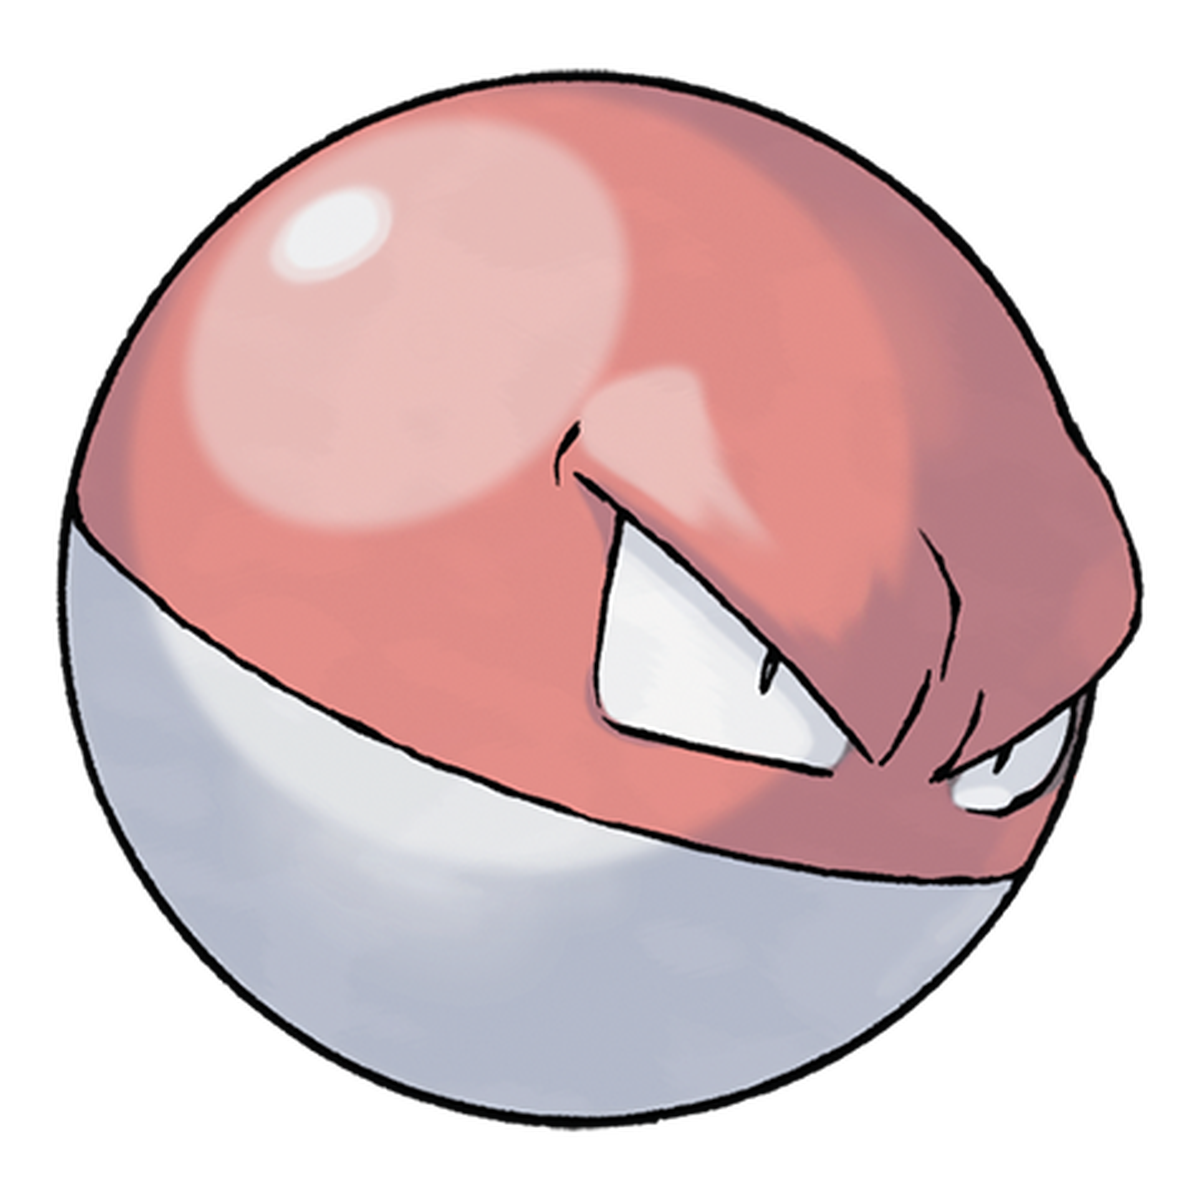

In [9]:
images = zipfile.ZipFile('images.zip','r')
Image.open(BytesIO(images.read('images/Voltorb.png')))

In [15]:
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model*_base_caption.pth'
    
model = blip_decoder(pretrained=model_url, image_size=384, vit='base')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

100%|██████████| 855M/855M [00:16<00:00, 53.4MB/s] 


load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model*_base_caption.pth


In [16]:
pokemon_description = pd.DataFrame()

counter = 0
for pokemon in tqdm(images.namelist()[2:]): # list of the images 

    if (pokemon[:6] == 'images') & (pokemon !='images/.DS_Store'):
        pokemon_name = pokemon[7:-4]

        raw_image = Image.open(BytesIO(images.read(pokemon))).convert('RGB')


        image_size = 384
        transform = transforms.Compose([
            transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
            ]) 
        image = transform(raw_image).unsqueeze(0).to(device)  



        model.eval()
        model = model.to(device)


        with torch.no_grad():
            caption = model.generate(image, sample=False, num_beams=3, max_length=20, min_length=10)

        pokemon_description = pd.concat([pokemon_description,
                                         pd.DataFrame(data = {'Pokemon': [pokemon_name],
                                                              'Caption': caption})])
        counter +=1
        if counter % 50 == 0:
#         pokemon_description.to_csv(f'poke{counter}.csv') 
#         files.download(f'poke{counter}.csv')
            print(f'Done with {counter} iterations!')

  5%|▍         | 54/1103 [00:47<04:03,  4.31it/s]  

Done with 50 iterations!


 10%|▉         | 107/1103 [01:01<03:48,  4.36it/s]

Done with 100 iterations!


 15%|█▍        | 163/1103 [01:15<03:49,  4.09it/s]

Done with 150 iterations!


 20%|█▉        | 219/1103 [01:28<03:50,  3.84it/s]

Done with 200 iterations!


 25%|██▍       | 272/1103 [01:41<03:52,  3.57it/s]

Done with 250 iterations!


 30%|██▉       | 329/1103 [01:55<03:20,  3.85it/s]

Done with 300 iterations!


 35%|███▌      | 387/1103 [02:07<02:48,  4.24it/s]

Done with 350 iterations!


 40%|████      | 442/1103 [02:21<02:38,  4.18it/s]

Done with 400 iterations!


 45%|████▍     | 496/1103 [02:34<02:47,  3.63it/s]

Done with 450 iterations!


 50%|████▉     | 550/1103 [02:48<02:14,  4.10it/s]

Done with 500 iterations!


 55%|█████▍    | 606/1103 [03:02<02:04,  4.00it/s]

Done with 550 iterations!


 60%|█████▉    | 659/1103 [03:15<01:32,  4.81it/s]

Done with 600 iterations!


 65%|██████▍   | 712/1103 [03:29<01:44,  3.75it/s]

Done with 650 iterations!


 70%|██████▉   | 767/1103 [03:42<01:02,  5.35it/s]

Done with 700 iterations!


 75%|███████▍  | 822/1103 [03:55<01:03,  4.44it/s]

Done with 750 iterations!


 79%|███████▉  | 874/1103 [04:09<00:50,  4.50it/s]

Done with 800 iterations!


 84%|████████▍ | 929/1103 [04:22<00:45,  3.83it/s]

Done with 850 iterations!


 89%|████████▉ | 986/1103 [04:37<00:38,  3.05it/s]

Done with 900 iterations!


 94%|█████████▍| 1039/1103 [04:50<00:13,  4.58it/s]

Done with 950 iterations!


 99%|█████████▉| 1093/1103 [05:03<00:02,  4.99it/s]

Done with 1000 iterations!


100%|██████████| 1103/1103 [05:05<00:00,  3.61it/s]


In [18]:
pokemon_description.to_csv('pokemon_image_descriptions.csv')